In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [2]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

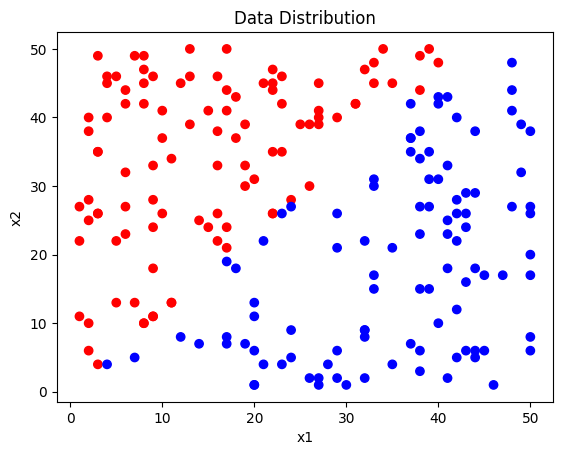

In [4]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [5]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

thresh = np.arange(0, 1, 0.001)

## Newton's Method

In [6]:
nwt = logRegAC.LogReg(max_iter=100, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=10, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  192.165
Iteration    10 | Cost:  16.863
Iteration    20 | Cost:  12.844
Iteration    30 | Cost:  11.252
Iteration    40 | Cost:  10.333
Iteration    50 | Cost:  9.710
Iteration    60 | Cost:  9.251
Iteration    70 | Cost:  8.892
Iteration    80 | Cost:  8.600
Iteration    90 | Cost:  8.355
Iteration   100 | Cost:  8.147
F1 Score:  1.0


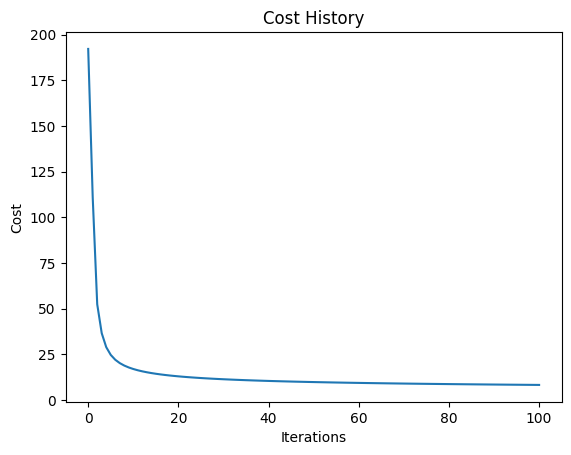

In [7]:
fig = plt.figure()
plt.plot(nwt.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/nwt_cost_hist.png')

In [8]:
nwt_trained_weights = nwt.get_params()
print(f'Trained Weights: {nwt_trained_weights}')
nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
nwt_cf_matrix = [[nwt_cf_info['tn'], nwt_cf_info['fn']], [nwt_cf_info['fp'], nwt_cf_info['tp']]]

Trained Weights: [[  0.87591247]
 [-31.70976126]
 [ 26.34562138]]


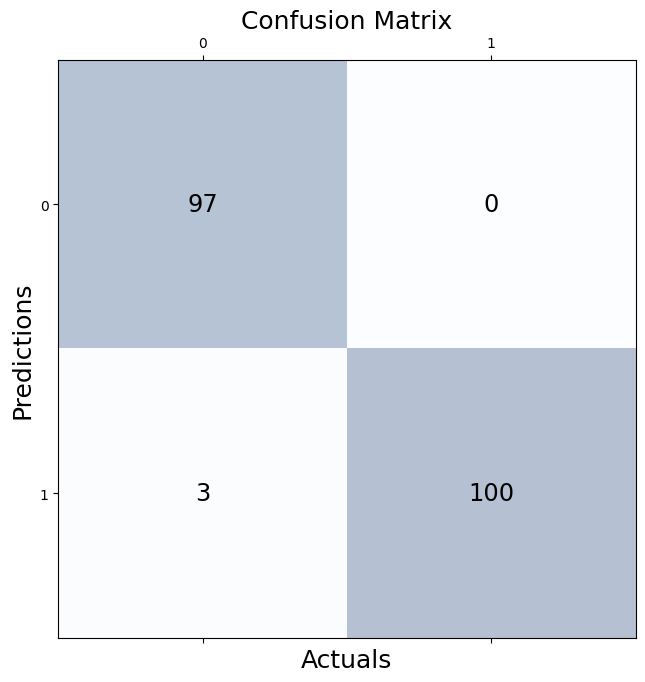

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(nwt_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(nwt_cf_matrix)):
    for j in range(len(nwt_cf_matrix[i])):
        ax.text(x=j, y=i,s=nwt_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/nwt_confusion_matrix.png')

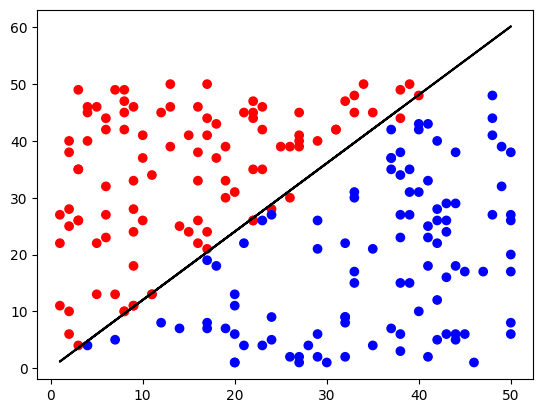

In [10]:
nwt_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], nwt_trained_weights).flatten()
nwt_plot_y = []
for i in range(len(nwt_vals)):
    nwt_plot_y.append(-(nwt_trained_weights[0] + (nwt_trained_weights[1] * data_x.iloc[i, 0])) / nwt_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], nwt_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/nwt_data_dist_db.png')

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:96: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


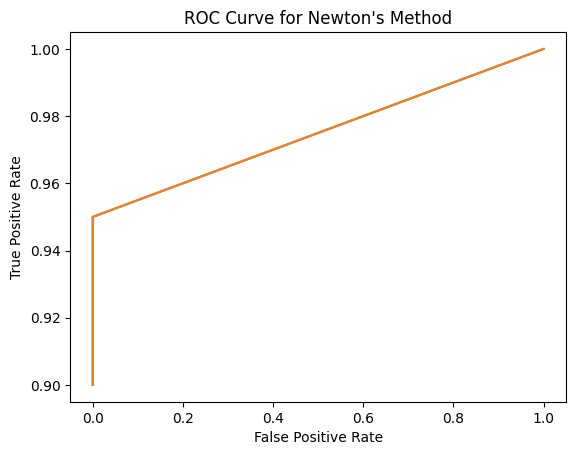

In [11]:
nwt_pred_prob = nwt.predict(data_x, prob=True)
nwt_tpr = []
nwt_fpr = []
for t in thresh:
    nwt_pred = [1 if i >= t else 0 for i in nwt_pred_prob]
    nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt_pred)
    tp = nwt_cf_info['tp']
    fp = nwt_cf_info['fp']
    tn = nwt_cf_info['tn']
    fn = nwt_cf_info['fn']
    nwt_tpr.append(tp/(tp+fn))
    nwt_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(nwt_fpr, nwt_tpr)
plt.plot(nwt_fpr, nwt_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Newton\'s Method')
plt.show()
fig.savefig('plots/nwt_roc.png')

## Using cross-validation Techniques

In [12]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [13]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.931
Iteration   200 | Cost:  25.610
Iteration   300 | Cost:  22.261
Iteration   400 | Cost:  20.204
Iteration   500 | Cost:  18.761
Iteration   600 | Cost:  17.668
Iteration   700 | Cost:  16.798
Iteration   800 | Cost:  16.083
Iteration   900 | Cost:  15.479
Iteration  1000 | Cost:  14.959
F1-score: 0.9565217391304348
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  43.556
Iteration   200 | Cost:  33.560
Iteration   300 | Cost:  29.034
Iteration   400 | Cost:  26.315
Iteration   500 | Cost:  24.443
Iteration   600 | Cost:  23.046
Iteration   700 | Cost:  21.948
Iteration   800 | Cost:  21.053
Iteration   900 | Cost:  20.302
Iteration  1000 | Cost:  19.660
F1-score: 0.9824561403508771
----------------- lr : 0.003 ---

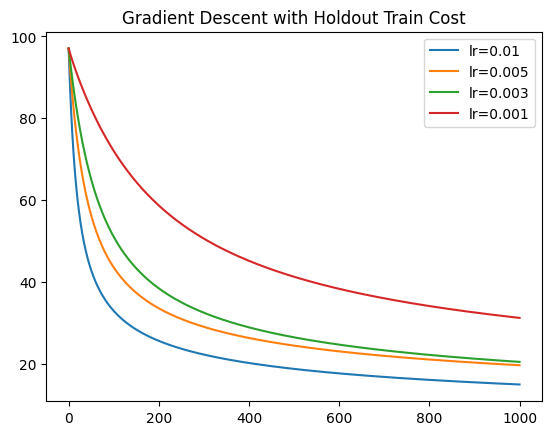

In [14]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [15]:
print(gd_hld_opt_model)

{'f1': 0.9824561403508771, 'lr': 0.005, 'w': array([[  0.5499741 ],
       [-10.94522783],
       [  9.00268891]])}


In [16]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

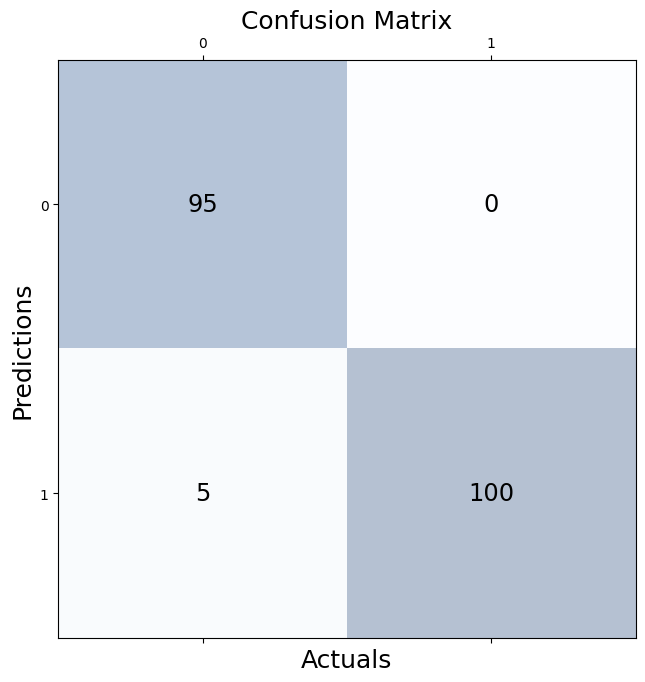

In [17]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

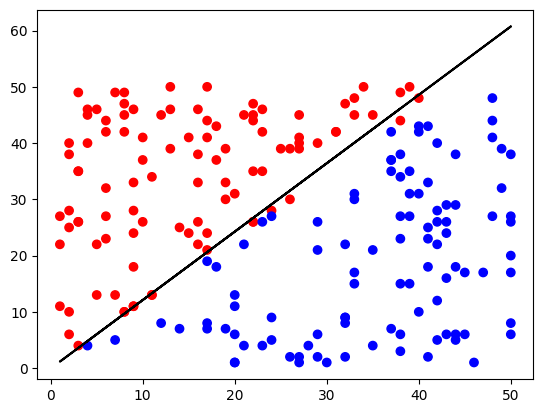

In [18]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

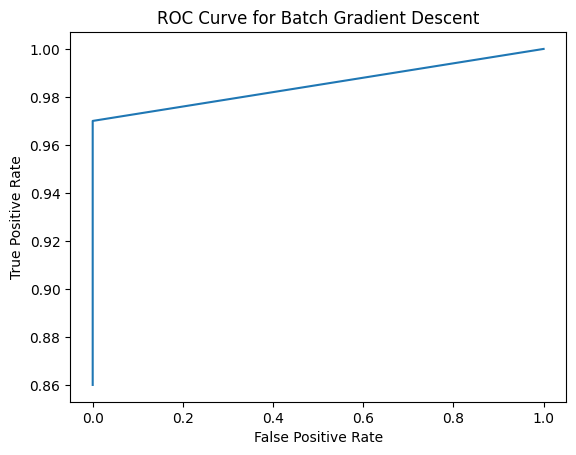

In [19]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [20]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.467
Iteration   200 | Cost:  25.507
Iteration   300 | Cost:  22.441
Iteration   400 | Cost:  20.598
Iteration   500 | Cost:  19.324
Iteration   600 | Cost:  18.372
Iteration   700 | Cost:  17.621
Iteration   800 | Cost:  17.008
Iteration   900 | Cost:  16.494
Iteration  1000 | Cost:  16.054
F1-score: 0.9795918367346939
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  40.980
Iteration   200 | Cost:  30.952
Iteration   300 | Cost:  26.399
Iteration   400 | Cost:  23.672
Iteration   500 | Cost:  21.806
Iteration   600 | Cost:  20.427
Iteration   700 | Cost:  19.353
Iteration   800 | Cost:  18.485
Iteration   900 | Cost:  17.765
Iteration  1000 | Cost:  17.154
F1-score: 0.9846153846153847
----------------- lr :

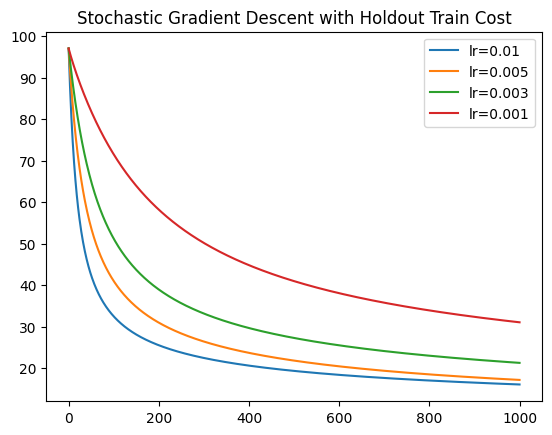

In [21]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [22]:
print(sgd_hld_opt_model)

{'f1': 0.9846153846153847, 'lr': 0.005, 'w': array([[  0.66157535],
       [-11.07526021],
       [  8.87712685]])}


In [23]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

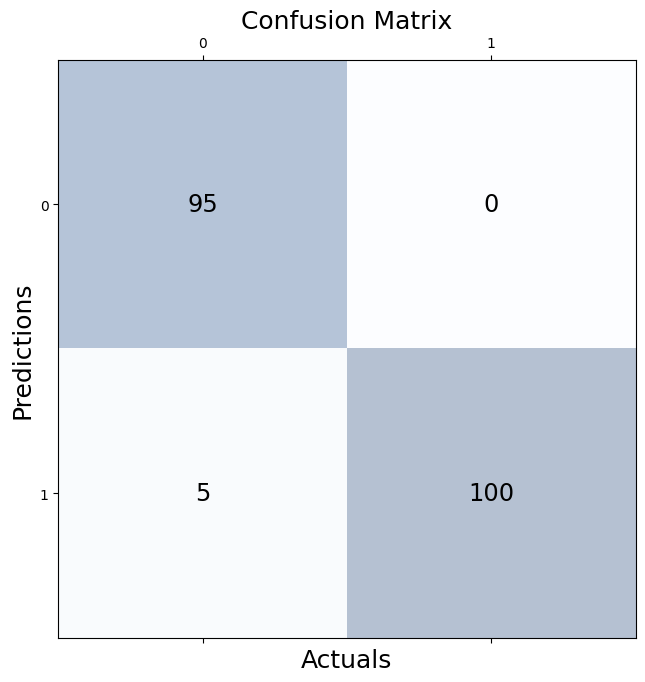

In [24]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

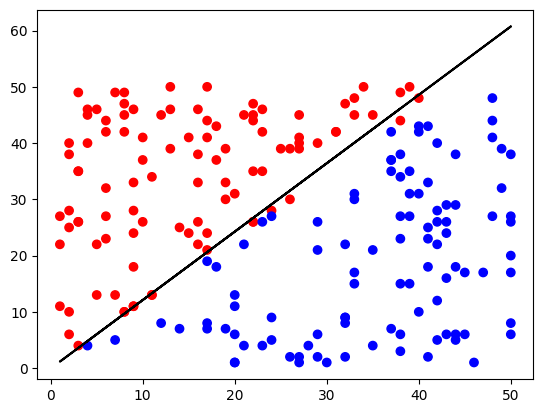

In [25]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

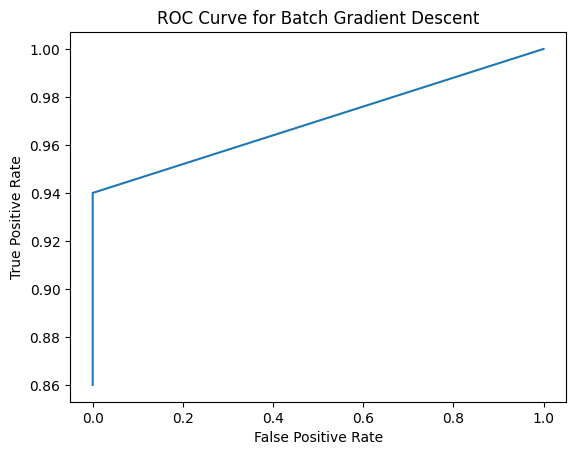

In [26]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [27]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation with n = 5.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.026
Iteration   200 | Cost:  22.843
Iteration   300 | Cost:  19.676
Iteration   400 | Cost:  17.783
Iteration   500 | Cost:  16.483
Iteration   600 | Cost:  15.516
Iteration   700 | Cost:  14.759
Iteration   800 | Cost:  14.144
Iteration   900 | Cost:  13.631
Iteration  1000 | Cost:  13.193
F1-score: 0.9696969696969697
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  33.447
Iteration   200 | Cost:  26.063
Iteration   300 | Cost:  22.804
Iteration   400 | Cost:  20.851
Iteration   500 | Cost:  19.504
Iteration   600 | Cost:  18.496
Iteration   700 | Cost:  17.702
Iteration   800 | Cost:  17.052
Iteration   900 | Cost:  16.505
Iteration  1000 | Cost:  16.037
F1-score: 0.9836065573770492
----------------- 

In [28]:
print(gd_montc_opt_model)

{'f1': 0.9669427566968551, 'lr': 0.01, 'w': array([[  1.17432805],
       [-14.26490634],
       [ 11.07506757]])}


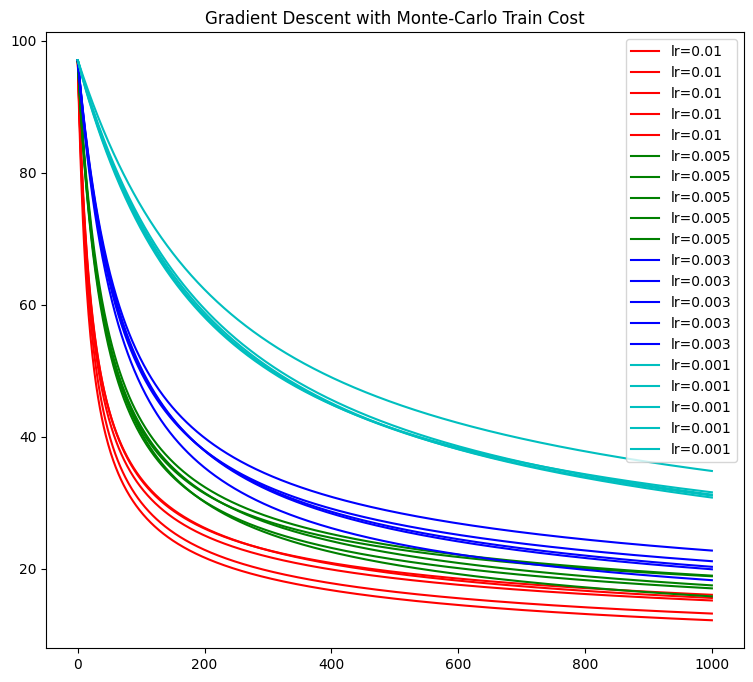

In [29]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [30]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation with n = 5.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.671
Iteration   200 | Cost:  23.324
Iteration   300 | Cost:  20.055
Iteration   400 | Cost:  18.093
Iteration   500 | Cost:  16.742
Iteration   600 | Cost:  15.736
Iteration   700 | Cost:  14.949
Iteration   800 | Cost:  14.308
Iteration   900 | Cost:  13.774
Iteration  1000 | Cost:  13.320
F1-score: 0.9846153846153847
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.032
Iteration   200 | Cost:  22.893
Iteration   300 | Cost:  19.727
Iteration   400 | Cost:  17.823
Iteration   500 | Cost:  16.509
Iteration   600 | Cost:  15.527
Iteration   700 | Cost:  14.754
Iteration   800 | Cost:  14.124
Iteration   900 | Cost:  13.596
Iteration  1000 | Cost:  13.145
F1-score: 0.9491525423728815
--------

In [31]:
print(sgd_montc_opt_model)

{'f1': 0.9686210261330185, 'lr': 0.01, 'w': array([[  0.73910675],
       [-13.9999275 ],
       [ 11.50885073]])}


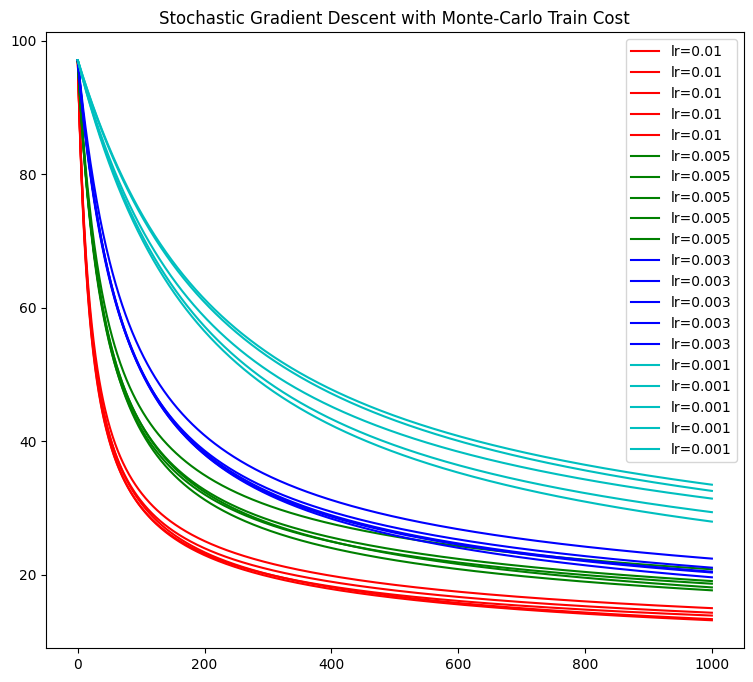

In [32]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [33]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation with k = 6.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.714
Iteration   200 | Cost:  27.755
Iteration   300 | Cost:  24.196
Iteration   400 | Cost:  22.047
Iteration   500 | Cost:  20.558
Iteration   600 | Cost:  19.443
Iteration   700 | Cost:  18.564
Iteration   800 | Cost:  17.847
Iteration   900 | Cost:  17.245
Iteration  1000 | Cost:  16.731
F1-score: 0.975609756097561
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.957
Iteration   200 | Cost:  27.295
Iteration   300 | Cost:  23.867
Iteration   400 | Cost:  21.791
Iteration   500 | Cost:  20.349
Iteration   600 | Cost:  19.266
Iteration   700 | Cost:  18.411
Iteration   800 | Cost:  17.712
Iteration   900 | Cost:  17.124
Iteration  1000 | Cost:  16.621
F1-score: 1.0
----------------- lr : 0.01 ---------

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  18.031
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.496
Iteration   200 | Cost:  28.185
Iteration   300 | Cost:  24.458
Iteration   400 | Cost:  22.205
Iteration   500 | Cost:  20.646
Iteration   600 | Cost:  19.480
Iteration   700 | Cost:  18.563
Iteration   800 | Cost:  17.815
Iteration   900 | Cost:  17.188
Iteration  1000 | Cost:  16.654
F1-score: 0.967741935483871
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  32.957
Iteration   200 | Cost:  25.160
Iteration   300 | Cost:  21.723
Iteration   400 | Cost:  19.667
Iteration   500 | Cost:  18.257
Iteration   600 | Cost:  17.209
Iteration   700 | Cost:  16.390
Iteration   800 | Cost:  15.726
Iteration   900 | Cost:  15.173
Iteration  1000 | Cost:  14.703
F1-score: 0.9523809523809523
Average F1-score for lr=0

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  47.028
Iteration   200 | Cost:  35.766
Iteration   300 | Cost:  30.676
Iteration   400 | Cost:  27.614
Iteration   500 | Cost:  25.505
Iteration   600 | Cost:  23.933
Iteration   700 | Cost:  22.700
Iteration   800 | Cost:  21.697
Iteration   900 | Cost:  20.859
Iteration  1000 | Cost:  20.144
F1-score: 0.975609756097561
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.525
Iteration   200 | Cost:  35.524
Iteration   300 | Cost:  30.621
Iteration   400 | Cost:  27.688
Iteration   500 | Cost:  25.674
Iteration   600 | Cost:  24.174
Iteration   700 | Cost:  22.997
Iteration   800 | Cost:  22.039
Iteration   900 | Cost:  21.238
Iteration  1000 | Cost:  20.554
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  45.916
Iteration   200 | Cost:  34.410
Iteration   300 | Co

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   300 | Cost:  33.829
Iteration   400 | Cost:  30.091
Iteration   500 | Cost:  27.567
Iteration   600 | Cost:  25.719
Iteration   700 | Cost:  24.292
Iteration   800 | Cost:  23.146
Iteration   900 | Cost:  22.200
Iteration  1000 | Cost:  21.401
F1-score: 0.923076923076923
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.188
Iteration   200 | Cost:  43.498
Iteration   300 | Cost:  37.103
Iteration   400 | Cost:  33.239
Iteration   500 | Cost:  30.582
Iteration   600 | Cost:  28.610
Iteration   700 | Cost:  27.068
Iteration   800 | Cost:  25.818
Iteration   900 | Cost:  24.776
Iteration  1000 | Cost:  23.891
F1-score: 0.9743589743589743
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.946
Iteration   200 | Cost:  45.110
Iteration   300 | Cost:  38.681
Iteration   400 | Cost:  34.826
Itera

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   300 | Cost:  35.999
Iteration   400 | Cost:  32.060
Iteration   500 | Cost:  29.365
Iteration   600 | Cost:  27.372
Iteration   700 | Cost:  25.819
Iteration   800 | Cost:  24.564
Iteration   900 | Cost:  23.522
Iteration  1000 | Cost:  22.637
F1-score: 0.8695652173913044
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  56.345
Iteration   200 | Cost:  42.751
Iteration   300 | Cost:  36.453
Iteration   400 | Cost:  32.679
Iteration   500 | Cost:  30.101
Iteration   600 | Cost:  28.196
Iteration   700 | Cost:  26.713
Iteration   800 | Cost:  25.514
Iteration   900 | Cost:  24.519
Iteration  1000 | Cost:  23.674
F1-score: 0.9787234042553191
Average F1-score for lr=0.003: 0.9535557125300137
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.289
Iteration   200 | Cost:  67.048
Iteration   300 | 

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   400 | Cost:  50.624
Iteration   500 | Cost:  46.262
Iteration   600 | Cost:  42.981
Iteration   700 | Cost:  40.407
Iteration   800 | Cost:  38.322
Iteration   900 | Cost:  36.593
Iteration  1000 | Cost:  35.129
F1-score: 0.975609756097561
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.508
Iteration   200 | Cost:  65.109
Iteration   300 | Cost:  55.765
Iteration   400 | Cost:  49.719
Iteration   500 | Cost:  45.455
Iteration   600 | Cost:  42.262
Iteration   700 | Cost:  39.765
Iteration   800 | Cost:  37.747
Iteration   900 | Cost:  36.073
Iteration  1000 | Cost:  34.657
F1-score: 0.962962962962963
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.862
Iteration   200 | Cost:  66.540
Iteration   300 | Cost:  57.054
Iteration   400 | Cost:  50.843
Iteration   500 | Cost:  46.429
Iterat

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


In [34]:
print(gd_kfold_opt_model)

{'f1': 0.971510996215953, 'lr': 0.01, 'w': array([[  1.04161203],
       [-15.22811758],
       [ 11.7881027 ]])}


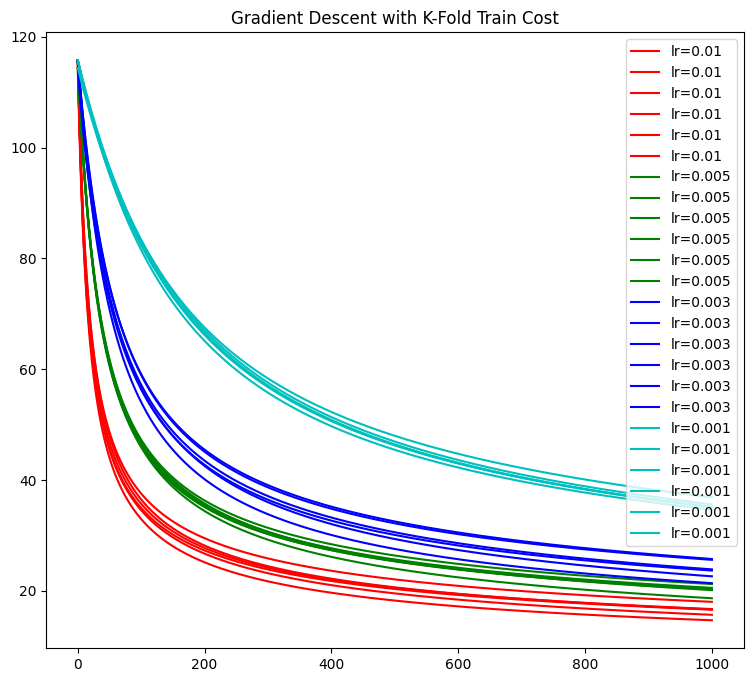

In [35]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [36]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation with k = 6.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  33.385
Iteration   200 | Cost:  25.640


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  22.228
Iteration   400 | Cost:  20.189
Iteration   500 | Cost:  18.789
Iteration   600 | Cost:  17.748
Iteration   700 | Cost:  16.933
Iteration   800 | Cost:  16.271
Iteration   900 | Cost:  15.719
Iteration  1000 | Cost:  15.248
F1-score: 0.9714285714285714
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.376


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  28.249
Iteration   300 | Cost:  24.592
Iteration   400 | Cost:  22.376
Iteration   500 | Cost:  20.840
Iteration   600 | Cost:  19.690
Iteration   700 | Cost:  18.785
Iteration   800 | Cost:  18.047
Iteration   900 | Cost:  17.429
Iteration  1000 | Cost:  16.902
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  36.238
Iteration   200 | Cost:  28.139
Iteration   300 | Cost:  24.499
Iteration   400 | Cost:  22.293
Iteration   500 | Cost:  20.763
Iteration   600 | Cost:  19.615
Iteration   700 | Cost:  18.711
Iteration   800 | Cost:  17.972
Iteration   900 | Cost:  17.353
Iteration  1000 | Cost:  16.824
F1-score: 0.972972972972973
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.667
Iteration   200 | Cost:  27.754


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.218
Iteration   400 | Cost:  22.074
Iteration   500 | Cost:  20.582
Iteration   600 | Cost:  19.459
Iteration   700 | Cost:  18.570
Iteration   800 | Cost:  17.840
Iteration   900 | Cost:  17.225
Iteration  1000 | Cost:  16.697
F1-score: 0.9600000000000001
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  33.727


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  25.916
Iteration   300 | Cost:  22.442
Iteration   400 | Cost:  20.347
Iteration   500 | Cost:  18.897
Iteration   600 | Cost:  17.812
Iteration   700 | Cost:  16.958
Iteration   800 | Cost:  16.262
Iteration   900 | Cost:  15.678
Iteration  1000 | Cost:  15.180
F1-score: 0.9473684210526316
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  37.470
Iteration   200 | Cost:  29.177
Iteration   300 | Cost:  25.440
Iteration   400 | Cost:  23.172
Iteration   500 | Cost:  21.597
Iteration   600 | Cost:  20.415
Iteration   700 | Cost:  19.484
Iteration   800 | Cost:  18.724
Iteration   900 | Cost:  18.086
Iteration  1000 | Cost:  17.541
F1-score: 1.0
Average F1-score for lr=0.01: 0.9752949942423627
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  43.113
Iteration   200 | Cost:  32.002


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  27.112
Iteration   400 | Cost:  24.221
Iteration   500 | Cost:  22.255
Iteration   600 | Cost:  20.805
Iteration   700 | Cost:  19.675
Iteration   800 | Cost:  18.762
Iteration   900 | Cost:  18.003
Iteration  1000 | Cost:  17.357
F1-score: 0.918918918918919
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  48.518


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  37.275
Iteration   300 | Cost:  32.170
Iteration   400 | Cost:  29.095
Iteration   500 | Cost:  26.976
Iteration   600 | Cost:  25.397
Iteration   700 | Cost:  24.157
Iteration   800 | Cost:  23.147
Iteration   900 | Cost:  22.303
Iteration  1000 | Cost:  21.581
F1-score: 0.967741935483871
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  47.149
Iteration   200 | Cost:  36.204
Iteration   300 | Cost:  31.289
Iteration   400 | Cost:  28.337
Iteration   500 | Cost:  26.305
Iteration   600 | Cost:  24.790
Iteration   700 | Cost:  23.601
Iteration   800 | Cost:  22.633
Iteration   900 | Cost:  21.823
Iteration  1000 | Cost:  21.132
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  48.478
Iteration   200 | Cost:  37.073


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  31.888
Iteration   400 | Cost:  28.761
Iteration   500 | Cost:  26.605
Iteration   600 | Cost:  24.995
Iteration   700 | Cost:  23.731
Iteration   800 | Cost:  22.701
Iteration   900 | Cost:  21.840
Iteration  1000 | Cost:  21.105
F1-score: 0.972972972972973
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  48.594


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  37.032
Iteration   300 | Cost:  31.860
Iteration   400 | Cost:  28.781
Iteration   500 | Cost:  26.679
Iteration   600 | Cost:  25.125
Iteration   700 | Cost:  23.913
Iteration   800 | Cost:  22.932
Iteration   900 | Cost:  22.117
Iteration  1000 | Cost:  21.424
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  44.208
Iteration   200 | Cost:  33.327
Iteration   300 | Cost:  28.512
Iteration   400 | Cost:  25.652
Iteration   500 | Cost:  23.700
Iteration   600 | Cost:  22.255
Iteration   700 | Cost:  21.127
Iteration   800 | Cost:  20.213
Iteration   900 | Cost:  19.451
Iteration  1000 | Cost:  18.803
F1-score: 0.9696969696969697
Average F1-score for lr=0.005: 0.9715551328454555
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.633
Iteration   200 | Cost:  43.973


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  37.625
Iteration   400 | Cost:  33.813
Iteration   500 | Cost:  31.210
Iteration   600 | Cost:  29.286
Iteration   700 | Cost:  27.790
Iteration   800 | Cost:  26.582
Iteration   900 | Cost:  25.579
Iteration  1000 | Cost:  24.729
F1-score: 0.967741935483871
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.780


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  43.748
Iteration   300 | Cost:  37.169
Iteration   400 | Cost:  33.196
Iteration   500 | Cost:  30.468
Iteration   600 | Cost:  28.443
Iteration   700 | Cost:  26.861
Iteration   800 | Cost:  25.578
Iteration   900 | Cost:  24.509
Iteration  1000 | Cost:  23.600
F1-score: 0.9189189189189189
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  55.643
Iteration   200 | Cost:  41.734
Iteration   300 | Cost:  35.384
Iteration   400 | Cost:  31.623
Iteration   500 | Cost:  29.079
Iteration   600 | Cost:  27.214
Iteration   700 | Cost:  25.772
Iteration   800 | Cost:  24.613
Iteration   900 | Cost:  23.655
Iteration  1000 | Cost:  22.844
F1-score: 0.9444444444444444
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.567
Iteration   200 | Cost:  43.519


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  36.951
Iteration   400 | Cost:  32.992
Iteration   500 | Cost:  30.277
Iteration   600 | Cost:  28.264
Iteration   700 | Cost:  26.693
Iteration   800 | Cost:  25.420
Iteration   900 | Cost:  24.360
Iteration  1000 | Cost:  23.459
F1-score: 0.9375
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.226


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  44.206
Iteration   300 | Cost:  37.658
Iteration   400 | Cost:  33.721
Iteration   500 | Cost:  31.028
Iteration   600 | Cost:  29.036
Iteration   700 | Cost:  27.484
Iteration   800 | Cost:  26.230
Iteration   900 | Cost:  25.188
Iteration  1000 | Cost:  24.304
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  56.332
Iteration   200 | Cost:  43.021
Iteration   300 | Cost:  36.900
Iteration   400 | Cost:  33.237
Iteration   500 | Cost:  30.734
Iteration   600 | Cost:  28.880
Iteration   700 | Cost:  27.434
Iteration   800 | Cost:  26.262
Iteration   900 | Cost:  25.285
Iteration  1000 | Cost:  24.453
F1-score: 0.9714285714285714
Average F1-score for lr=0.003: 0.9566723117126342
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  80.939
Iteration   200 | Cost:  64.281


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  54.821
Iteration   400 | Cost:  48.718
Iteration   500 | Cost:  44.425
Iteration   600 | Cost:  41.217
Iteration   700 | Cost:  38.713
Iteration   800 | Cost:  36.693
Iteration   900 | Cost:  35.021
Iteration  1000 | Cost:  33.609
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.783


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  65.541
Iteration   300 | Cost:  56.298
Iteration   400 | Cost:  50.316
Iteration   500 | Cost:  46.095
Iteration   600 | Cost:  42.931
Iteration   700 | Cost:  40.454
Iteration   800 | Cost:  38.451
Iteration   900 | Cost:  36.789
Iteration  1000 | Cost:  35.383
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  81.740
Iteration   200 | Cost:  65.320
Iteration   300 | Cost:  55.896
Iteration   400 | Cost:  49.776
Iteration   500 | Cost:  45.452
Iteration   600 | Cost:  42.210
Iteration   700 | Cost:  39.673
Iteration   800 | Cost:  37.621
Iteration   900 | Cost:  35.920
Iteration  1000 | Cost:  34.480
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.998
Iteration   200 | Cost:  66.533


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  56.874
Iteration   400 | Cost:  50.506
Iteration   500 | Cost:  45.958
Iteration   600 | Cost:  42.523
Iteration   700 | Cost:  39.819
Iteration   800 | Cost:  37.624
Iteration   900 | Cost:  35.798
Iteration  1000 | Cost:  34.249
F1-score: 0.888888888888889
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.309


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  68.225
Iteration   300 | Cost:  58.713
Iteration   400 | Cost:  52.418
Iteration   500 | Cost:  47.912
Iteration   600 | Cost:  44.504
Iteration   700 | Cost:  41.818
Iteration   800 | Cost:  39.635
Iteration   900 | Cost:  37.818
Iteration  1000 | Cost:  36.275
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  85.017
Iteration   200 | Cost:  69.680
Iteration   300 | Cost:  60.505
Iteration   400 | Cost:  54.398
Iteration   500 | Cost:  50.012
Iteration   600 | Cost:  46.685
Iteration   700 | Cost:  44.058
Iteration   800 | Cost:  41.919
Iteration   900 | Cost:  40.134
Iteration  1000 | Cost:  38.616
F1-score: 1.0
Average F1-score for lr=0.001: 0.9707287933094385


In [37]:
print(sgd_kfold_opt_model)

{'f1': 0.9752949942423627, 'lr': 0.01, 'w': array([[  0.87333853],
       [-15.45796618],
       [ 12.20836757]])}


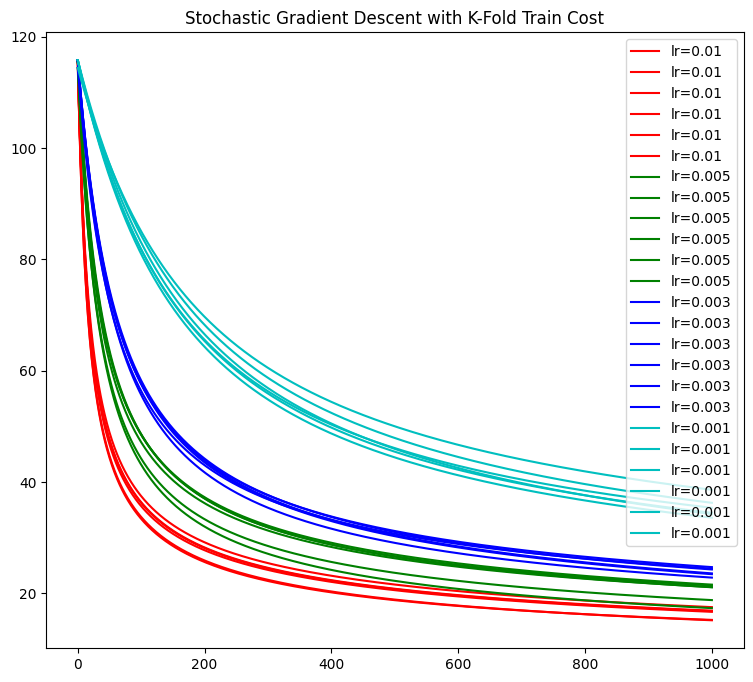

In [38]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [39]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  33.317
Iteration   200 | Cost:  25.601
Iteration   300 | Cost:  22.142
Iteration   400 | Cost:  20.051
Iteration   500 | Cost:  18.604
Iteration   600 | Cost:  17.521
Iteration   700 | Cost:  16.669
Iteration   800 | Cost:  15.976
Iteration   900 | Cost:  15.395
Iteration  1000 | Cost:  14.900
F1 Score:  0.9333333333333332


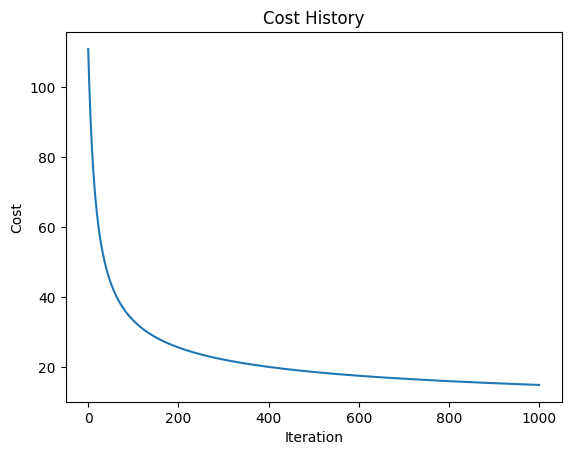

In [40]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [41]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  0.93509779]
 [-15.0969199 ]
 [ 11.86609551]]


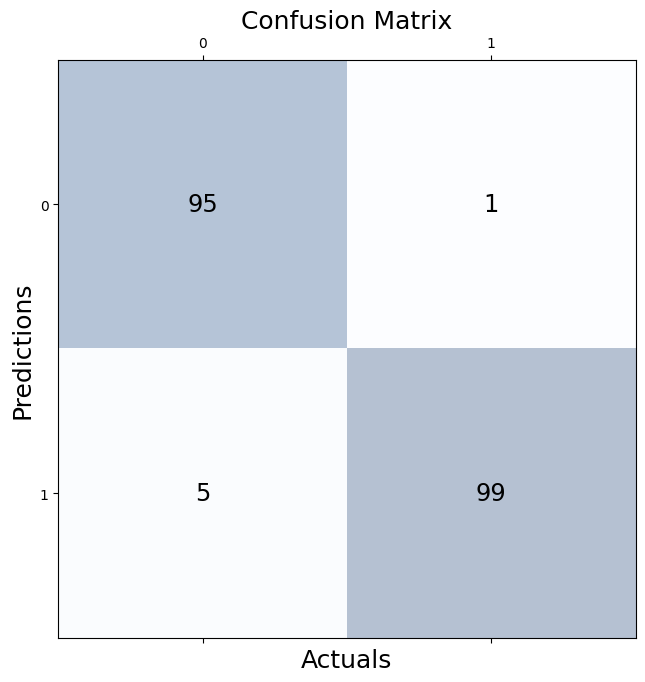

In [42]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

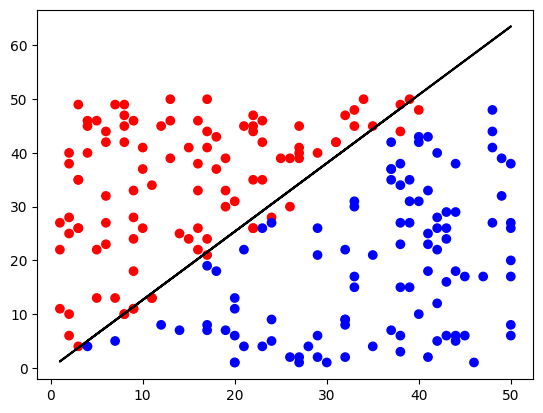

In [43]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

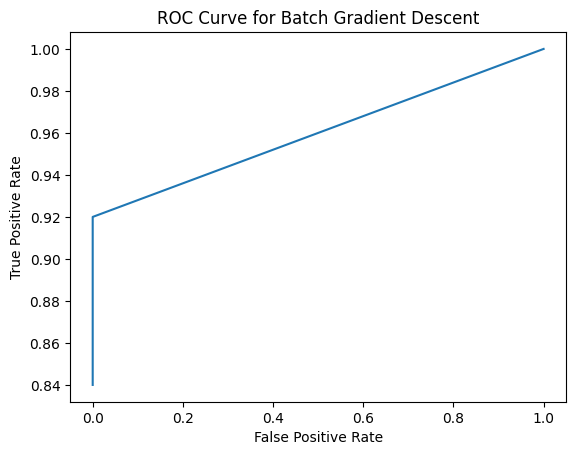

In [44]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [45]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGD=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  33.419
Iteration   200 | Cost:  25.645
Iteration   300 | Cost:  22.167
Iteration   400 | Cost:  20.067
Iteration   500 | Cost:  18.615
Iteration   600 | Cost:  17.529
Iteration   700 | Cost:  16.675
Iteration   800 | Cost:  15.980
Iteration   900 | Cost:  15.399
Iteration  1000 | Cost:  14.903
F1 Score:  0.9333333333333332


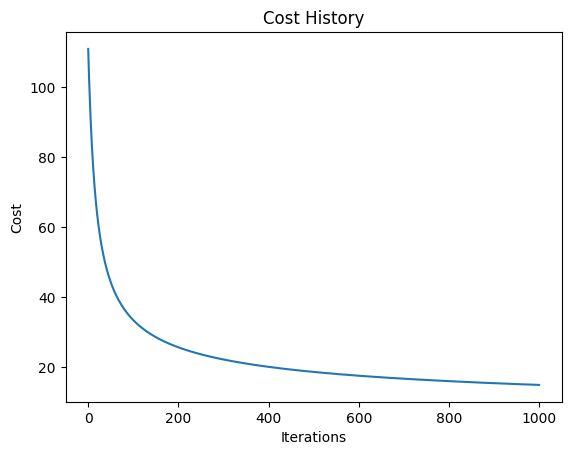

In [46]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [47]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  0.92855708]
 [-15.09606845]
 [ 11.86208306]]


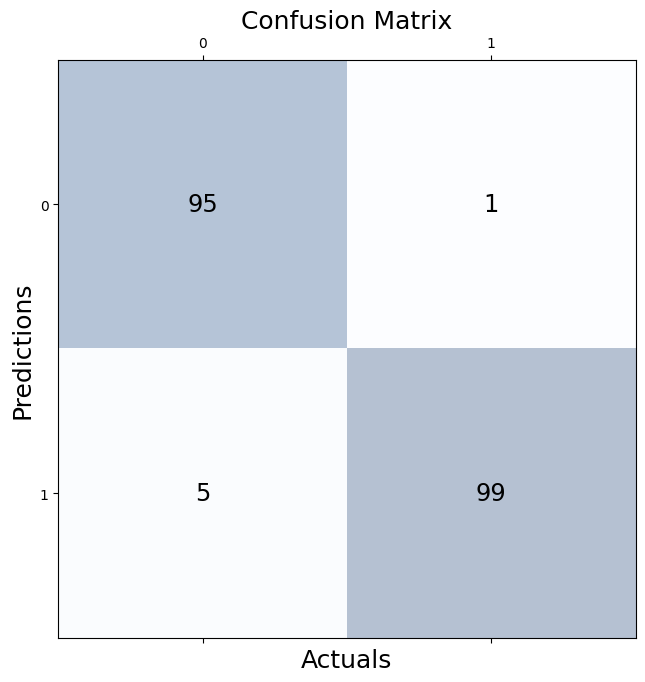

In [48]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

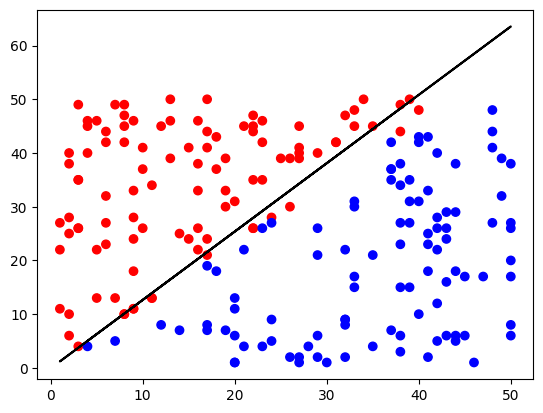

In [49]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

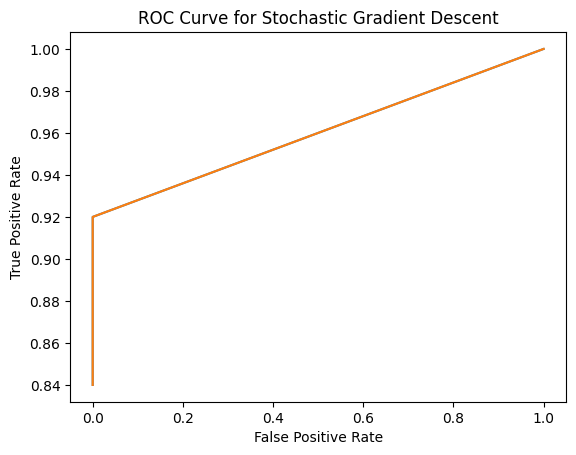

In [50]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')